In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np

## Downloading Data

**NEWS**

In [ ]:
df_news = pd.read_csv("boeing_news.csv")
df_news_2 = pd.read_csv("boeing_news_2.csv")
df_news_0 = pd.read_csv("boeing_news_0.csv")

df_news = pd.concat([df_news, df_news_2, df_news_0], ignore_index=True)

In [ ]:
df_news['time_published'] = df_news['time_published'].apply(lambda x: datetime.datetime.strptime(x, "%Y%m%dT%H%M%S"))
df_news = df_news.sort_values(by='time_published', ascending=False)
df_news.drop(columns=['title','url','summary','overall_sentiment_label','ticker_relevance_score','ticker_sentiment_label'],inplace=True)
df_news['time_published'] = df_news['time_published'].dt.date

In [ ]:
df_news.head()

,overall_sentiment_score,ticker_sentiment_score,time_published
4189,0.145621,-0.034966,2023-10-29
4190,-0.297852,-0.597090,2023-10-28
4191,0.031191,-0.005256,2023-10-28
4192,0.060719,-0.108086,2023-10-28
4193,0.212744,0.023002,2023-10-28


In [ ]:
df = df_news
# Function to compute quantiles
def compute_quantiles(x, quantiles):
    return x.quantile(quantiles)

quantiles = [0.15, 0.25, 0.5, 0.75, 0.85]

# Group by 'time_published' and compute quantiles for ticker_sentiment_score and overall_sentiment_score
ticker_quantiles = df.groupby('time_published')['ticker_sentiment_score'].apply(lambda x: compute_quantiles(x, quantiles))
overall_quantiles = df.groupby('time_published')['overall_sentiment_score'].apply(lambda x: compute_quantiles(x, quantiles))

ticker_quantiles_df = ticker_quantiles.unstack().reset_index()
ticker_quantiles_df.columns = ['time_published', 'ticker_0.15', 'ticker_0.25', 'ticker_0.5', 'ticker_0.75', 'ticker_0.85']

overall_quantiles_df = overall_quantiles.unstack().reset_index()
overall_quantiles_df.columns = ['time_published', 'overall_0.15', 'overall_0.25', 'overall_0.5', 'overall_0.75', 'overall_0.85']

# Compute the number of cases for each date
case_counts = df['time_published'].value_counts().reset_index()
case_counts.columns = ['time_published', 'number_of_cases']

# Merge quantile results and case counts
df = pd.merge(ticker_quantiles_df, overall_quantiles_df, on='time_published', how='outer')
df = pd.merge(df, case_counts, on='time_published', how='outer')


**FINANCE**

In [ ]:
#params - ^GSPC - SNP_500, EURUSD=X - EUR to USD rate, BA - Boeing Company
ticker_list = ['^GSPC', 'EURUSD=X', 'BA']
begin_date = "20220801"
end_date = "20231029"

yfd = YFinanseDownloader(ticker_list,begin_date,end_date)

In [ ]:
df2 = yfd.create_df()

[*********************100%%**********************]  1 of 1 completed
Ticker data downloaded correctly
[*********************100%%**********************]  1 of 1 completed
Ticker data downloaded correctly
[*********************100%%**********************]  1 of 1 completed
Ticker data downloaded correctly


In [ ]:
df2['Date'] = df2['Date'].dt.date

## Merge News and Finance

In [ ]:
df_full = pd.merge(df2, df, left_on='Date',right_on='time_published', how='outer')

In [ ]:
df_full.to_csv("boeing_full_220801_231029.csv")

In [ ]:
df_full = pd.read_csv("boeing_full_220801_231029.csv")

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          455 non-null    int64  
 1   Date                455 non-null    object 
 2   ^GSPC_Open          314 non-null    float64
 3   ^GSPC_High          314 non-null    float64
 4   ^GSPC_Low           314 non-null    float64
 5   ^GSPC_Close         314 non-null    float64
 6   ^GSPC_Adj Close     314 non-null    float64
 7   ^GSPC_Volume        314 non-null    float64
 8   EURUSD=X_Open       325 non-null    float64
 9   EURUSD=X_High       325 non-null    float64
 10  EURUSD=X_Low        325 non-null    float64
 11  EURUSD=X_Close      325 non-null    float64
 12  EURUSD=X_Adj Close  325 non-null    float64
 13  EURUSD=X_Volume     325 non-null    float64
 14  BA_Open             314 non-null    float64
 15  BA_High             314 non-null    float64
 16  BA_Low  

In [ ]:
df_full.drop(columns = ["time_published","EURUSD=X_Volume"],inplace=True)


In [ ]:
news_col = ["ticker_0.15","ticker_0.25",
                                 "ticker_0.5","ticker_0.75","ticker_0.85",
                                 "overall_0.15","overall_0.25","overall_0.5",
                                 "overall_0.75", "overall_0.85","number_of_cases"]

**replace NA with ffill for finance and 0 for news**

In [ ]:
# Specify the columns to forward-fill (modify this list according to your columns)
columns_to_ffill = df_full.drop(columns = news_col).columns
# Forward-fill the specified columns from df_usd to match every day in df_btc
df_full_ff = df_full
df_full_ff[columns_to_ffill] = df_full[columns_to_ffill].transform('ffill')


In [ ]:
df_full_ff[news_col] = df_full_ff[news_col].fillna(0)

**add preprocessed date columns**

In [ ]:
df_full_ff["Date"] = pd.to_datetime(df_full_ff["Date"])

df_full_ff['month'] = df_full_ff['Date'].dt.month
df_full_ff['day'] = df_full_ff['Date'].dt.day

# Calculate 'year_progress' and 'month_progress'
df_full_ff['year_progress'] = df_full_ff['month'] / 12
df_full_ff['month_progress'] = np.round(df_full_ff['day'] / 31,2)

In [ ]:
df_full_ff['Target'] = (df_full_ff['BA_Close']-df_full_ff['BA_Close'].shift(1)) / df_full_ff['BA_Close'].shift(1)


In [ ]:
df_full_ff.columns

Index(['Unnamed: 0', 'Date', '^GSPC_Open', '^GSPC_High', '^GSPC_Low',
       '^GSPC_Close', '^GSPC_Volume', 'EURUSD=X_Open', 'EURUSD=X_High',
       'EURUSD=X_Low', 'EURUSD=X_Close', 'BA_Open', 'BA_High', 'BA_Low',
       'BA_Close', 'BA_Volume', 'is_weekend', 'ticker_0.15', 'ticker_0.25',
       'ticker_0.5', 'ticker_0.75', 'ticker_0.85', 'overall_0.15',
       'overall_0.25', 'overall_0.5', 'overall_0.75', 'overall_0.85',
       'number_of_cases', 'year_progress', 'month_progress', 'Target', 'month',
       'day'],
      dtype='object')

In [ ]:
adj_columns = [col for col in df_full_ff.columns if (col.endswith('Adj Close'))]
df_full_ff.drop(columns=adj_columns,inplace=True)

df_full_ff.drop(columns=['Unnamed: 0','month','day'],inplace=True)

**normalization**

In [ ]:
def norm_by_divide_max(df,test,prefix,prc=1):
  a_columns = [col for col in df.columns if (col.startswith(prefix) and not col.endswith('Volume'))]

  # Find the max value across prefix columns
  max_value = df[a_columns].max().max()

  # Divide all selected columns by the max value
  df[a_columns] = df[a_columns] / (max_value*prc)
  test[a_columns] = test[a_columns] / (max_value*prc)

  return max_value, a_columns

In [ ]:
test = df_full_ff[-40:]
train = df_full_ff[:-40]

In [ ]:
vol_columns = [col for col in train.columns if (col.endswith('Volume'))]
max_v = np.max(train[vol_columns])

train[vol_columns] = train[vol_columns]/ max_v
test[vol_columns] = test[vol_columns]/ max_v

col = ['number_of_cases']
max_n = np.max(train[col])

train[col] = train[col]/ max_n
test[col] = test[col]/ max_n

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
<ipython-input-13-a2d294013232>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[vol_columns] = train[vol_columns]/ max_v
<ipython-input-13-a2d294013232>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [ ]:
norm_by_divide_max(train,test,"^GSPC",1.5)
norm_by_divide_max(train,test,"EURUSD",1.5)
norm_by_divide_max(train,test,"BA",1.5)

<ipython-input-11-dbc3b88cc6d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[a_columns] = df[a_columns] / (max_value*prc)
<ipython-input-11-dbc3b88cc6d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[a_columns] = test[a_columns] / (max_value*prc)
<ipython-input-11-dbc3b88cc6d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

(243.1000061035156, ['BA_Open', 'BA_High', 'BA_Low', 'BA_Close'])

# model

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  #input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  #forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  if i == 0:
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  #put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  #drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy(dtype=np.float32)
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
train.loc[train['is_weekend'] ==True,'is_weekend'] = 1
train.loc[train['is_weekend'] ==False,'is_weekend'] = 0
train['is_weekend']=train['is_weekend'].astype(float)

<ipython-input-18-06b4e4299737>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_weekend']=train['is_weekend'].astype(float)


In [ ]:
test.loc[test['is_weekend'] ==True,'is_weekend'] = 1
test.loc[test['is_weekend'] ==False,'is_weekend'] = 0
test['is_weekend']=test['is_weekend'].astype(float)

<ipython-input-19-d6ce2a474d1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['is_weekend']=test['is_weekend'].astype(float)


1.

In [ ]:
window_size = 21
batch_size = 32
shuffle_buffer_size = 1000

train_data = np.array(train[1:].drop(columns=['Date']),dtype=np.float32)

# Generate the dataset windows
train_set = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)

2.

In [ ]:
X,y = df_to_X_y2(train[1:].drop(columns=['Date']),window_size = 7)

In [ ]:
X.shape

(407, 7, 29)

In [ ]:
X_test,y_test = df_to_X_y2(test.drop(columns=['Date']),window_size = 7)

In [ ]:
y = y*100
y_test = y_test*100

3.

In [ ]:
X_train = series_to_supervised(train.drop(columns=['Date']), n_in=20, n_out=1, dropnan=True)

In [ ]:
y_train = train['Target'].shift(1)[23:]

In [ ]:
X_train = X_train[:-2]

In [ ]:
X_test = series_to_supervised(test.drop(columns=['Date']), n_in=20, n_out=1, dropnan=True)

In [ ]:
y_test = test['Target'].shift(1)[22:]

In [ ]:
X_test = X_test[:-2]

In [ ]:
y_train = y_train*10
y_test = y_test*10

3. model

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[X_train.shape[1], 1]),
  tf.keras.layers.LSTM(16, return_sequences=True),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dense(10, activation="relu"),
  #tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 0.01)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 609, 64)           256       
                                                                 
 lstm (LSTM)                 (None, 609, 16)           5184      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 7733 (30.21 KB)
Trainable params: 7733 (30.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
13/13 [==============================] - 4s 38ms/step - loss: 10.1922 - lr: 1.0000e-05
Epoch 2/100
13/13 [==============================] - 0s 29ms/step - loss: 10.1922 - lr: 1.1220e-05
Epoch 3/100
13/13 [==============================] - 0s 29ms/step - loss: 10.1922 - lr: 1.2589e-05
Epoch 4/100
13/13 [==============================] - 0s 29ms/step - loss: 10.1922 - lr: 1.4125e-05
Epoch 5/100
13/13 [==============================] - 0s 29ms/step - loss: 10.1922 - lr: 1.5849e-05
Epoch 6/100
13/13 [==============================] - 0s 29ms/step - loss: 10.1922 - lr: 1.7783e-05
Epoch 7/100
13/13 [==============================] - 0s 29ms/step - loss: 10.1922 - lr: 1.9953e-05
Epoch 8/100
13/13 [==============================] - 0s 30ms/step - loss: 10.1921 - lr: 2.2387e-05
Epoch 9/100
13/13 [==============================] - 0s 30ms/step - loss: 10.1921 - lr: 2.5119e-05
Epoch 10/100
13/13 [==============================] - 0s 31ms/step - loss: 10.1921 - lr: 2.8184e-05
Epoch 11/

In [ ]:
tf.keras.backend.clear_session()

# Set the learning rate
learning_rate = 8e-4
#10e-7
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [ ]:
history = model.fit(X_train, y_train, epochs=300)

Epoch 1/300
13/13 [==============================] - 4s 44ms/step - loss: 10.1914 - mse: 313.0037
Epoch 2/300
13/13 [==============================] - 0s 32ms/step - loss: 10.1913 - mse: 312.9992
Epoch 3/300
13/13 [==============================] - 0s 32ms/step - loss: 10.1913 - mse: 312.9965
Epoch 4/300
13/13 [==============================] - 0s 33ms/step - loss: 10.1912 - mse: 312.9923
Epoch 5/300
13/13 [==============================] - 0s 32ms/step - loss: 10.1912 - mse: 312.9902
Epoch 6/300
13/13 [==============================] - 0s 33ms/step - loss: 10.1911 - mse: 312.9877
Epoch 7/300
13/13 [==============================] - 0s 33ms/step - loss: 10.1911 - mse: 312.9865
Epoch 8/300
13/13 [==============================] - 0s 32ms/step - loss: 10.1911 - mse: 312.9838
Epoch 9/300
13/13 [==============================] - 0s 32ms/step - loss: 10.1911 - mse: 312.9838
Epoch 10/300
13/13 [==============================] - 0s 31ms/step - loss: 10.1911 - mse: 312.9828
Epoch 11/300
13/13 

In [ ]:
results = model.predict(X_test)
results = results.flatten()
print(tf.keras.metrics.mean_squared_error(y_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(y_test, results).numpy())

1/1 [==============================] - 1s 636ms/step
1.9641337
0.9227047


1/1 [==============================] - 0s 32ms/step
186.64198
8.039821


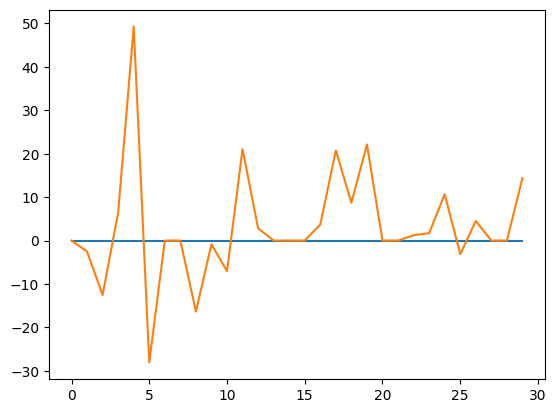

In [ ]:
results = model.predict(X_train[-30:])
results = results.flatten()
print(tf.keras.metrics.mean_squared_error(y_train[-30:], results).numpy())
print(tf.keras.metrics.mean_absolute_error(y_train[-30:], results).numpy())
plt.plot([i for i in range(30)], results)
plt.plot([i for i in range(30)], y_train[-30:])

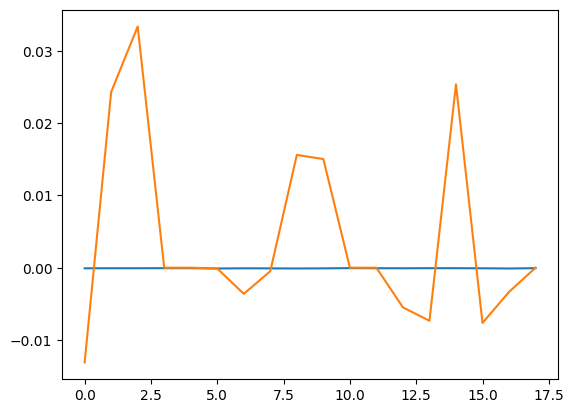

In [ ]:
plt.plot([i for i in range(18)], results)
plt.plot([i for i in range(18)], y_test)

(1e-05, 0.1, 10.19, 10.2)

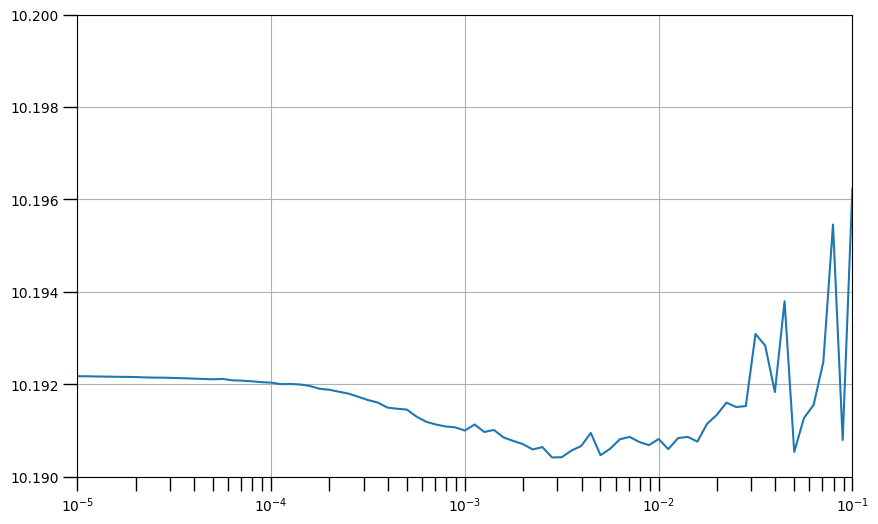

In [ ]:
from matplotlib import pyplot as plt
# Define the learning rate array
lrs = 1e-5 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-5, 1e-1, 10.19, 10.2])

In [ ]:
tf.keras.backend.clear_session()

# Set the learning rate
learning_rate = 8e-7
#10e-7
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer((7,29)),
  tf.keras.layers.Conv1D(filters=64, kernel_size=2,
                     strides=1, padding="causal",
                     activation="relu"),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(4, 'relu'),
  tf.keras.layers.Dense(1, 'linear')
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 14, 64)            3776      
                                                                 
 lstm_2 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 24649 (96.29 KB)
Trainable params: 24649 (96.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), metrics=[RootMeanSquaredError()])

In [ ]:
model.fit(X, y, epochs=1000, callbacks=[cp4])

Epoch 1/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0606 - root_mean_squared_error: 1.7495

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 2/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 3/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 4/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.2545 - root_mean_squared_error: 1.8040

13/13 [==============================] - 0s 15ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 5/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0917 - root_mean_squared_error: 1.7583

13/13 [==============================] - 0s 14ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 6/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.2463 - root_mean_squared_error: 1.8017

13/13 [==============================] - 0s 12ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 7/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.1084 - root_mean_squared_error: 1.7631

13/13 [==============================] - 0s 12ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 8/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 9/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8404 - root_mean_squared_error: 1.6854

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 10/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2572 - root_mean_squared_error: 1.8048

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 11/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1393 - root_mean_squared_error: 1.7718

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 12/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1766 - root_mean_squared_error: 1.7823

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 13/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2242 - root_mean_squared_error: 1.7956

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 14/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.1278 - root_mean_squared_error: 1.7686

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 15/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2740 - root_mean_squared_error: 1.8094

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 16/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7122 - root_mean_squared_error: 1.6469

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 17/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3452 - root_mean_squared_error: 1.8290

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 18/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8921 - root_mean_squared_error: 1.7006

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 19/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7438 - root_mean_squared_error: 1.6564

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 20/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0974 - root_mean_squared_error: 1.7599

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 21/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1138 - root_mean_squared_error: 1.7646

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 22/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8147 - root_mean_squared_error: 1.6777

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 23/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9771 - root_mean_squared_error: 1.7254

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 24/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0612 - root_mean_squared_error: 1.7496

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 25/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0754 - root_mean_squared_error: 1.7537

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 26/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2981 - root_mean_squared_error: 1.8161

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 27/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0413 - root_mean_squared_error: 1.7439

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 28/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1429 - root_mean_squared_error: 1.7728

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 29/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0591 - root_mean_squared_error: 1.7490

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 30/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1906 - root_mean_squared_error: 1.7862

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 31/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2059 - root_mean_squared_error: 1.7905

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 32/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7682 - root_mean_squared_error: 1.6638

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 33/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9940 - root_mean_squared_error: 1.7303

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 34/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1437 - root_mean_squared_error: 1.7730

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 35/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9990 - root_mean_squared_error: 1.7317

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 36/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2076 - root_mean_squared_error: 1.7910

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 37/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.5827 - root_mean_squared_error: 1.6071

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 38/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8296 - root_mean_squared_error: 1.6821

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 39/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3621 - root_mean_squared_error: 1.8336

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 40/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2556 - root_mean_squared_error: 1.8043

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 41/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9092 - root_mean_squared_error: 1.7056

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 42/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1198 - root_mean_squared_error: 1.7663

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 43/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3338 - root_mean_squared_error: 1.8259

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 44/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1798 - root_mean_squared_error: 1.7832

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 45/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1749 - root_mean_squared_error: 1.7818

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 46/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8811 - root_mean_squared_error: 1.6974

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 47/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1827 - root_mean_squared_error: 1.7840

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 48/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3532 - root_mean_squared_error: 1.8312

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 49/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3576 - root_mean_squared_error: 1.8324

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 50/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1673 - root_mean_squared_error: 1.7797

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 51/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2905 - root_mean_squared_error: 1.8140

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 52/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6922 - root_mean_squared_error: 1.6408

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 53/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2408 - root_mean_squared_error: 1.8002

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 54/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3780 - root_mean_squared_error: 1.8379

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 55/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0482 - root_mean_squared_error: 1.7459

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 56/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0459 - root_mean_squared_error: 1.7453

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 57/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9959 - root_mean_squared_error: 1.7309

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 58/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2082 - root_mean_squared_error: 1.7911

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 59/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4127 - root_mean_squared_error: 1.8473

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 60/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9302 - root_mean_squared_error: 1.7118

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 61/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8467 - root_mean_squared_error: 1.6872

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 62/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3670 - root_mean_squared_error: 1.8349

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 63/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2404 - root_mean_squared_error: 1.8001

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 64/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9425 - root_mean_squared_error: 1.7154

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 65/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0417 - root_mean_squared_error: 1.7440

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 66/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1386 - root_mean_squared_error: 1.7716

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 67/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3457 - root_mean_squared_error: 1.8291

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 68/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.4937 - root_mean_squared_error: 1.5792

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 69/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9210 - root_mean_squared_error: 1.7091

13/13 [==============================] - 0s 6ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 70/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0514 - root_mean_squared_error: 1.7468

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 71/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9626 - root_mean_squared_error: 1.7212

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 72/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1798 - root_mean_squared_error: 1.7832

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 73/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.5032 - root_mean_squared_error: 1.8717

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 74/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0900 - root_mean_squared_error: 1.7578

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 75/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9081 - root_mean_squared_error: 1.7053

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 76/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1018 - root_mean_squared_error: 1.7612

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 77/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4742 - root_mean_squared_error: 1.8639

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 78/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9835 - root_mean_squared_error: 1.7273

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 79/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0088 - root_mean_squared_error: 1.7346

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 80/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2377 - root_mean_squared_error: 1.7994

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 81/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1932 - root_mean_squared_error: 1.7869

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 82/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0497 - root_mean_squared_error: 1.7464

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 83/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8698 - root_mean_squared_error: 1.6941

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 84/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0607 - root_mean_squared_error: 1.7495

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 85/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3464 - root_mean_squared_error: 1.8293

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 86/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0430 - root_mean_squared_error: 1.7444

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 87/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2464 - root_mean_squared_error: 1.8018

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 88/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1264 - root_mean_squared_error: 1.7682

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 89/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.5879 - root_mean_squared_error: 1.8942

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 90/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7689 - root_mean_squared_error: 1.6640

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 91/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0483 - root_mean_squared_error: 1.7459

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 92/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2362 - root_mean_squared_error: 1.7989

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 93/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9498 - root_mean_squared_error: 1.7175

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 94/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9751 - root_mean_squared_error: 1.7249

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 95/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0677 - root_mean_squared_error: 1.7515

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 96/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.5977 - root_mean_squared_error: 1.6118

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 97/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9602 - root_mean_squared_error: 1.7205

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 98/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7633 - root_mean_squared_error: 1.6623

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 99/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4238 - root_mean_squared_error: 1.8503

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 100/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1499 - root_mean_squared_error: 1.7748

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 101/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9671 - root_mean_squared_error: 1.7225

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 102/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 103/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.2779 - root_mean_squared_error: 1.8105

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 104/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0576 - root_mean_squared_error: 1.7486

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 105/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9630 - root_mean_squared_error: 1.7213

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 106/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7213 - root_mean_squared_error: 1.6496

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 107/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0144 - root_mean_squared_error: 1.7362

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 108/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1458 - root_mean_squared_error: 1.7736

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 109/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0226 - root_mean_squared_error: 1.7386

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 110/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3143 - root_mean_squared_error: 1.8205

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 111/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9500 - root_mean_squared_error: 1.7176

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 112/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2262 - root_mean_squared_error: 1.7962

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 113/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 114/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.8577 - root_mean_squared_error: 1.9641

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 115/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3922 - root_mean_squared_error: 1.8418

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 116/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9417 - root_mean_squared_error: 1.7151

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 117/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8929 - root_mean_squared_error: 1.7008

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 118/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 119/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1470 - root_mean_squared_error: 1.7740

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 120/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8642 - root_mean_squared_error: 1.6924

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 121/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9133 - root_mean_squared_error: 1.7069

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 122/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6961 - root_mean_squared_error: 1.6420

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 123/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9757 - root_mean_squared_error: 1.7250

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 124/1000
13/13 [==============================] - ETA: 0s - loss: 3.1012 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 125/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.2382 - root_mean_squared_error: 1.7995

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 126/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8233 - root_mean_squared_error: 1.6803

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 127/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7769 - root_mean_squared_error: 1.6664

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 128/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.4963 - root_mean_squared_error: 1.5800

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 129/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1723 - root_mean_squared_error: 1.7811

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 130/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3278 - root_mean_squared_error: 1.8242

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 131/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 132/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.7077 - root_mean_squared_error: 1.6455

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 133/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6108 - root_mean_squared_error: 1.9002

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 134/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 135/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5989 - root_mean_squared_error: 1.6121

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 136/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0686 - root_mean_squared_error: 1.7517

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 137/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.6631 - root_mean_squared_error: 1.9139

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 138/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8383 - root_mean_squared_error: 1.6847

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 139/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0915 - root_mean_squared_error: 1.7583

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 140/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2825 - root_mean_squared_error: 1.8118

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 141/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1168 - root_mean_squared_error: 1.7654

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 142/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1842 - root_mean_squared_error: 1.7844

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 143/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8146 - root_mean_squared_error: 1.6777

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 144/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0628 - root_mean_squared_error: 1.7501

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 145/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2152 - root_mean_squared_error: 1.7931

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 146/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.6750 - root_mean_squared_error: 1.6356

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 147/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2147 - root_mean_squared_error: 1.7930

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 148/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2690 - root_mean_squared_error: 1.8080

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 149/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1888 - root_mean_squared_error: 1.7857

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 150/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3317 - root_mean_squared_error: 1.8253

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 151/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2785 - root_mean_squared_error: 1.8107

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 152/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3515 - root_mean_squared_error: 1.8307

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 153/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1890 - root_mean_squared_error: 1.7858

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 154/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1301 - root_mean_squared_error: 1.7692

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 155/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3298 - root_mean_squared_error: 1.8248

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 156/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2236 - root_mean_squared_error: 1.7954

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 157/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.6257 - root_mean_squared_error: 1.6204

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 158/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3181 - root_mean_squared_error: 1.8216

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 159/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8954 - root_mean_squared_error: 1.7016

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 160/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.5139 - root_mean_squared_error: 1.8745

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 161/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1672 - root_mean_squared_error: 1.7797

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 162/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3160 - root_mean_squared_error: 1.8210

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 163/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3048 - root_mean_squared_error: 1.8179

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 164/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0647 - root_mean_squared_error: 1.7506

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 165/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2180 - root_mean_squared_error: 1.7939

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 166/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0919 - root_mean_squared_error: 1.7584

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 167/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0394 - root_mean_squared_error: 1.7434

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 168/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9767 - root_mean_squared_error: 1.7253

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 169/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3837 - root_mean_squared_error: 1.8395

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 170/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7777 - root_mean_squared_error: 1.6667

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 171/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1272 - root_mean_squared_error: 1.7684

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 172/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9555 - root_mean_squared_error: 1.7192

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 173/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2030 - root_mean_squared_error: 1.7897

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 174/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9860 - root_mean_squared_error: 1.7280

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 175/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.6077 - root_mean_squared_error: 1.6149

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 176/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2465 - root_mean_squared_error: 1.8018

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 177/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3800 - root_mean_squared_error: 1.8385

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 178/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2595 - root_mean_squared_error: 1.8054

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 179/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1287 - root_mean_squared_error: 1.7688

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 180/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0638 - root_mean_squared_error: 1.7504

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 181/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0653 - root_mean_squared_error: 1.7508

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 182/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4121 - root_mean_squared_error: 1.8472

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 183/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9461 - root_mean_squared_error: 1.7164

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 184/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0552 - root_mean_squared_error: 1.7479

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 185/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2039 - root_mean_squared_error: 1.7899

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 186/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9341 - root_mean_squared_error: 1.7129

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 187/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1288 - root_mean_squared_error: 1.7689

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 188/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4820 - root_mean_squared_error: 1.8660

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 189/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3447 - root_mean_squared_error: 1.8289

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 190/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.5812 - root_mean_squared_error: 1.6066

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 191/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9312 - root_mean_squared_error: 1.7121

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 192/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2112 - root_mean_squared_error: 1.7920

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 193/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3279 - root_mean_squared_error: 1.8243

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 194/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1322 - root_mean_squared_error: 1.7698

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 195/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1654 - root_mean_squared_error: 1.7792

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 196/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9810 - root_mean_squared_error: 1.7265

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 197/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1546 - root_mean_squared_error: 1.7761

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 198/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1237 - root_mean_squared_error: 1.7674

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 199/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4907 - root_mean_squared_error: 1.8683

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 200/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2367 - root_mean_squared_error: 1.7991

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 201/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.5231 - root_mean_squared_error: 1.5884

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 202/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2983 - root_mean_squared_error: 1.8161

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 203/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3454 - root_mean_squared_error: 1.8291

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 204/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8880 - root_mean_squared_error: 1.6994

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 205/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2336 - root_mean_squared_error: 1.7982

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 206/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1371 - root_mean_squared_error: 1.7712

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 207/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9503 - root_mean_squared_error: 1.7177

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 208/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2169 - root_mean_squared_error: 1.7936

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 209/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3192 - root_mean_squared_error: 1.8219

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 210/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9481 - root_mean_squared_error: 1.7170

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 211/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9373 - root_mean_squared_error: 1.7139

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 212/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2158 - root_mean_squared_error: 1.7933

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 213/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1762 - root_mean_squared_error: 1.7822

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 214/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9958 - root_mean_squared_error: 1.7308

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 215/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2859 - root_mean_squared_error: 1.8127

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 216/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2922 - root_mean_squared_error: 1.8144

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 217/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7756 - root_mean_squared_error: 1.6660

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 218/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9695 - root_mean_squared_error: 1.7232

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 219/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3432 - root_mean_squared_error: 1.8284

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 220/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0113 - root_mean_squared_error: 1.7353

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 221/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.5827 - root_mean_squared_error: 1.8928

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 222/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1560 - root_mean_squared_error: 1.7765

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 223/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1268 - root_mean_squared_error: 1.7683

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 224/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0264 - root_mean_squared_error: 1.7397

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 225/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7961 - root_mean_squared_error: 1.6721

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 226/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9953 - root_mean_squared_error: 1.7307

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 227/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2827 - root_mean_squared_error: 1.8118

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 228/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9201 - root_mean_squared_error: 1.7088

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 229/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8705 - root_mean_squared_error: 1.6942

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 230/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4916 - root_mean_squared_error: 1.8686

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 231/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2058 - root_mean_squared_error: 1.7905

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 232/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7120 - root_mean_squared_error: 1.6468

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 233/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1520 - root_mean_squared_error: 1.7754

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 234/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4781 - root_mean_squared_error: 1.8650

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 235/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2849 - root_mean_squared_error: 1.8124

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 236/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9135 - root_mean_squared_error: 1.7069

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 237/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2037 - root_mean_squared_error: 1.7899

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 238/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 239/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0971 - root_mean_squared_error: 1.7599

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 240/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0704 - root_mean_squared_error: 1.7523

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 241/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8218 - root_mean_squared_error: 1.6798

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 242/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 243/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1028 - root_mean_squared_error: 1.7615

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 244/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9664 - root_mean_squared_error: 1.7223

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 245/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4253 - root_mean_squared_error: 1.8508

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 246/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 247/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 248/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0577 - root_mean_squared_error: 1.7486

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 249/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6313 - root_mean_squared_error: 1.9056

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 250/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7801 - root_mean_squared_error: 1.6674

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 251/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 252/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 253/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4763 - root_mean_squared_error: 1.8645

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 254/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5561 - root_mean_squared_error: 1.8858

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 255/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3203 - root_mean_squared_error: 1.8222

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 256/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 257/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1224 - root_mean_squared_error: 1.7670

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 258/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0375 - root_mean_squared_error: 1.7428

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 259/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.8953 - root_mean_squared_error: 1.9736

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 260/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0051 - root_mean_squared_error: 1.7335

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 261/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 262/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 263/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 264/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 265/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9130 - root_mean_squared_error: 1.7068

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 266/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 267/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0849 - root_mean_squared_error: 1.7564

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 268/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3662 - root_mean_squared_error: 1.8347

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 269/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.8067 - root_mean_squared_error: 1.6753

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 270/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 271/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2268 - root_mean_squared_error: 1.7963

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 272/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2358 - root_mean_squared_error: 1.7988

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 273/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6207 - root_mean_squared_error: 1.9028

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 274/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0038 - root_mean_squared_error: 1.7331

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 275/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4692 - root_mean_squared_error: 1.8626

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 276/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.5014 - root_mean_squared_error: 1.8712

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 277/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8430 - root_mean_squared_error: 1.6861

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 278/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1313 - root_mean_squared_error: 1.7695

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 279/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.4764 - root_mean_squared_error: 1.8645

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 280/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3362 - root_mean_squared_error: 1.8265

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 281/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0032 - root_mean_squared_error: 1.7330

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 282/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3000 - root_mean_squared_error: 1.8166

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 283/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0738 - root_mean_squared_error: 1.7532

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 284/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3160 - root_mean_squared_error: 1.8210

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 285/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1603 - root_mean_squared_error: 1.7777

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 286/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1084 - root_mean_squared_error: 1.7631

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 287/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9009 - root_mean_squared_error: 1.7032

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 288/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9082 - root_mean_squared_error: 1.7053

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 289/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1587 - root_mean_squared_error: 1.7773

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 290/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3899 - root_mean_squared_error: 1.8412

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 291/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1303 - root_mean_squared_error: 1.7693

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 292/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0623 - root_mean_squared_error: 1.7499

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 293/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2358 - root_mean_squared_error: 1.7988

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 294/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0851 - root_mean_squared_error: 1.7565

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 295/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7553 - root_mean_squared_error: 1.6599

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 296/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7804 - root_mean_squared_error: 1.6675

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 297/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.6688 - root_mean_squared_error: 1.6337

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 298/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2442 - root_mean_squared_error: 1.8012

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 299/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0812 - root_mean_squared_error: 1.7553

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 300/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2276 - root_mean_squared_error: 1.7965

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 301/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.5171 - root_mean_squared_error: 1.8754

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 302/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9158 - root_mean_squared_error: 1.7076

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 303/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2377 - root_mean_squared_error: 1.7994

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 304/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8809 - root_mean_squared_error: 1.6973

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 305/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3774 - root_mean_squared_error: 1.8378

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 306/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1506 - root_mean_squared_error: 1.7750

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 307/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2916 - root_mean_squared_error: 1.8143

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 308/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7521 - root_mean_squared_error: 1.6589

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 309/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7973 - root_mean_squared_error: 1.6725

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 310/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8073 - root_mean_squared_error: 1.6755

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 311/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9385 - root_mean_squared_error: 1.7142

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 312/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1510 - root_mean_squared_error: 1.7751

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 313/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.6644 - root_mean_squared_error: 1.6323

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 314/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9886 - root_mean_squared_error: 1.7288

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 315/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2402 - root_mean_squared_error: 1.8001

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 316/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9170 - root_mean_squared_error: 1.7079

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 317/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7554 - root_mean_squared_error: 1.6599

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 318/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0971 - root_mean_squared_error: 1.7599

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 319/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7262 - root_mean_squared_error: 1.6511

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 320/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1333 - root_mean_squared_error: 1.7701

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 321/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3007 - root_mean_squared_error: 1.8168

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 322/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9161 - root_mean_squared_error: 1.7077

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 323/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8892 - root_mean_squared_error: 1.6998

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 324/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9272 - root_mean_squared_error: 1.7109

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 325/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3376 - root_mean_squared_error: 1.8269

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 326/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2030 - root_mean_squared_error: 1.7897

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 327/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2077 - root_mean_squared_error: 1.7910

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 328/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1445 - root_mean_squared_error: 1.7733

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 329/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1732 - root_mean_squared_error: 1.7814

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 330/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3226 - root_mean_squared_error: 1.8228

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 331/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4374 - root_mean_squared_error: 1.8540

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 332/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1086 - root_mean_squared_error: 1.7631

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 333/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7136 - root_mean_squared_error: 1.6473

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 334/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9562 - root_mean_squared_error: 1.7194

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 335/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9277 - root_mean_squared_error: 1.7111

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 336/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9932 - root_mean_squared_error: 1.7301

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 337/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7352 - root_mean_squared_error: 1.6538

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 338/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4270 - root_mean_squared_error: 1.8512

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 339/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9751 - root_mean_squared_error: 1.7248

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 340/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2511 - root_mean_squared_error: 1.8031

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 341/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1799 - root_mean_squared_error: 1.7832

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 342/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8877 - root_mean_squared_error: 1.6993

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 343/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3517 - root_mean_squared_error: 1.8308

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 344/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9620 - root_mean_squared_error: 1.7210

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 345/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3476 - root_mean_squared_error: 1.8297

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 346/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0793 - root_mean_squared_error: 1.7548

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 347/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7764 - root_mean_squared_error: 1.6663

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 348/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0959 - root_mean_squared_error: 1.7595

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 349/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2940 - root_mean_squared_error: 1.8149

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 350/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3260 - root_mean_squared_error: 1.8237

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 351/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4852 - root_mean_squared_error: 1.8669

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 352/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0969 - root_mean_squared_error: 1.7598

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 353/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1475 - root_mean_squared_error: 1.7741

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 354/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1310 - root_mean_squared_error: 1.7695

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 355/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1871 - root_mean_squared_error: 1.7852

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 356/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9129 - root_mean_squared_error: 1.7067

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 357/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1645 - root_mean_squared_error: 1.7789

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 358/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2331 - root_mean_squared_error: 1.7981

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 359/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4539 - root_mean_squared_error: 1.8585

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 360/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7581 - root_mean_squared_error: 1.6608

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 361/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2024 - root_mean_squared_error: 1.7895

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 362/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4478 - root_mean_squared_error: 1.8568

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 363/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7798 - root_mean_squared_error: 1.6673

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 364/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7442 - root_mean_squared_error: 1.6565

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 365/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9327 - root_mean_squared_error: 1.7125

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 366/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1263 - root_mean_squared_error: 1.7681

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 367/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1920 - root_mean_squared_error: 1.7866

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 368/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7545 - root_mean_squared_error: 1.6597

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 369/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 370/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.5494 - root_mean_squared_error: 1.5967

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 371/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 372/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.9236 - root_mean_squared_error: 1.7099

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 373/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 374/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0698 - root_mean_squared_error: 1.7521

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 375/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9545 - root_mean_squared_error: 1.7189

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 376/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5747 - root_mean_squared_error: 1.8907

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 377/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8741 - root_mean_squared_error: 1.6953

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 378/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 379/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7579 - root_mean_squared_error: 1.6607

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 380/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8925 - root_mean_squared_error: 1.7007

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 381/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 382/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2205 - root_mean_squared_error: 1.7946

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 383/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.4211 - root_mean_squared_error: 1.5560

13/13 [==============================] - 0s 9ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 384/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8396 - root_mean_squared_error: 1.6851

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 385/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2591 - root_mean_squared_error: 1.8053

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 386/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0168 - root_mean_squared_error: 1.7369

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 387/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1191 - root_mean_squared_error: 1.7661

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 388/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.4522 - root_mean_squared_error: 1.5660

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 389/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5635 - root_mean_squared_error: 1.6011

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 390/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0328 - root_mean_squared_error: 1.7415

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 391/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4005 - root_mean_squared_error: 1.8440

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 392/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7284 - root_mean_squared_error: 1.6518

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 393/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9962 - root_mean_squared_error: 1.7310

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 394/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1267 - root_mean_squared_error: 1.7682

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 395/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2182 - root_mean_squared_error: 1.7939

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 396/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 397/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2098 - root_mean_squared_error: 1.7916

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 398/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4832 - root_mean_squared_error: 1.8663

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 399/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3021 - root_mean_squared_error: 1.8172

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 400/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8159 - root_mean_squared_error: 1.6781

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 401/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2866 - root_mean_squared_error: 1.8129

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 402/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.5115 - root_mean_squared_error: 1.5848

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 403/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9843 - root_mean_squared_error: 1.7275

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 404/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.5272 - root_mean_squared_error: 1.8781

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 405/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 406/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 407/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8901 - root_mean_squared_error: 1.7000

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 408/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 409/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2139 - root_mean_squared_error: 1.7927

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 410/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 411/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.6749 - root_mean_squared_error: 1.9170

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 412/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8794 - root_mean_squared_error: 1.6969

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 413/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5617 - root_mean_squared_error: 1.8872

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 414/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7086 - root_mean_squared_error: 1.6458

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 415/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2745 - root_mean_squared_error: 1.8096

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 416/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9368 - root_mean_squared_error: 1.7137

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 417/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2547 - root_mean_squared_error: 1.8041

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 418/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3539 - root_mean_squared_error: 1.8314

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 419/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1442 - root_mean_squared_error: 1.7732

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 420/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1609 - root_mean_squared_error: 1.7779

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 421/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2655 - root_mean_squared_error: 1.8071

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 422/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.4973 - root_mean_squared_error: 1.5803

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 423/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6037 - root_mean_squared_error: 1.8983

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 424/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8044 - root_mean_squared_error: 1.6746

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 425/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1776 - root_mean_squared_error: 1.7826

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 426/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9753 - root_mean_squared_error: 1.7249

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 427/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0806 - root_mean_squared_error: 1.7552

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 428/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.6360 - root_mean_squared_error: 1.9068

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 429/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.4446 - root_mean_squared_error: 1.5635

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 430/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7942 - root_mean_squared_error: 1.6716

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 431/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1573 - root_mean_squared_error: 1.7769

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 432/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.5062 - root_mean_squared_error: 1.5831

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 433/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3053 - root_mean_squared_error: 1.8180

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 434/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7836 - root_mean_squared_error: 1.6684

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 435/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0674 - root_mean_squared_error: 1.7514

13/13 [==============================] - 0s 7ms/step - loss: 3.1013 - root_mean_squared_error: 1.7610
Epoch 436/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1809 - root_mean_squared_error: 1.7835

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 437/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3207 - root_mean_squared_error: 1.8223

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 438/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8165 - root_mean_squared_error: 1.6782

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 439/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9723 - root_mean_squared_error: 1.7240

13/13 [==============================] - 0s 6ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 440/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3219 - root_mean_squared_error: 1.8226

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 441/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2639 - root_mean_squared_error: 1.8066

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 442/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0625 - root_mean_squared_error: 1.7500

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 443/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3387 - root_mean_squared_error: 1.8272

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 444/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8905 - root_mean_squared_error: 1.7001

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 445/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9040 - root_mean_squared_error: 1.7041

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 446/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.8260 - root_mean_squared_error: 1.6811

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 447/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1762 - root_mean_squared_error: 1.7822

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 448/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.6263 - root_mean_squared_error: 1.6206

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 449/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2319 - root_mean_squared_error: 1.7977

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 450/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.2199 - root_mean_squared_error: 1.7944

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 451/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8870 - root_mean_squared_error: 1.6991

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 452/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2342 - root_mean_squared_error: 1.7984

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 453/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6529 - root_mean_squared_error: 1.9113

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 454/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3372 - root_mean_squared_error: 1.8268

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 455/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0439 - root_mean_squared_error: 1.7447

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 456/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2136 - root_mean_squared_error: 1.7927

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 457/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1385 - root_mean_squared_error: 1.7716

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 458/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7600 - root_mean_squared_error: 1.6613

13/13 [==============================] - 0s 6ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 459/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3087 - root_mean_squared_error: 1.8190

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 460/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1716 - root_mean_squared_error: 1.7809

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 461/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5877 - root_mean_squared_error: 1.6086

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 462/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1310 - root_mean_squared_error: 1.7695

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 463/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8677 - root_mean_squared_error: 1.6934

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 464/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8943 - root_mean_squared_error: 1.7013

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 465/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2503 - root_mean_squared_error: 1.8028

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 466/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3680 - root_mean_squared_error: 1.8352

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 467/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0569 - root_mean_squared_error: 1.7484

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 468/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1094 - root_mean_squared_error: 1.7633

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 469/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6223 - root_mean_squared_error: 1.9032

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 470/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3850 - root_mean_squared_error: 1.8398

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 471/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3128 - root_mean_squared_error: 1.8201

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 472/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2887 - root_mean_squared_error: 1.8135

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 473/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1589 - root_mean_squared_error: 1.7773

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 474/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3685 - root_mean_squared_error: 1.8353

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 475/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6559 - root_mean_squared_error: 1.9120

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 476/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.5687 - root_mean_squared_error: 1.8891

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 477/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1793 - root_mean_squared_error: 1.7831

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 478/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.5189 - root_mean_squared_error: 1.5871

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 479/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.6093 - root_mean_squared_error: 1.8998

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 480/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1134 - root_mean_squared_error: 1.7645

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 481/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1229 - root_mean_squared_error: 1.7672

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 482/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0413 - root_mean_squared_error: 1.7439

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 483/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4814 - root_mean_squared_error: 1.8658

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 484/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9683 - root_mean_squared_error: 1.7229

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 485/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3528 - root_mean_squared_error: 1.8311

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 486/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0287 - root_mean_squared_error: 1.7403

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 487/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1166 - root_mean_squared_error: 1.7654

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 488/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.4031 - root_mean_squared_error: 1.5502

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 489/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0075 - root_mean_squared_error: 1.7342

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 490/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2548 - root_mean_squared_error: 1.8041

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 491/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8681 - root_mean_squared_error: 1.6935

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 492/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6795 - root_mean_squared_error: 1.6369

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 493/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.6360 - root_mean_squared_error: 1.9068

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 494/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7694 - root_mean_squared_error: 1.6641

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 495/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1268 - root_mean_squared_error: 1.7683

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 496/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3433 - root_mean_squared_error: 1.8285

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 497/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4139 - root_mean_squared_error: 1.8477

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 498/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9975 - root_mean_squared_error: 1.7313

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 499/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2747 - root_mean_squared_error: 1.8096

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 500/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.9426 - root_mean_squared_error: 1.7154

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 501/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0156 - root_mean_squared_error: 1.7366

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 502/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3488 - root_mean_squared_error: 1.8300

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 503/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1143 - root_mean_squared_error: 1.7647

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 504/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1953 - root_mean_squared_error: 1.7875

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 505/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4000 - root_mean_squared_error: 1.8439

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 506/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.0977 - root_mean_squared_error: 1.7600

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 507/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8542 - root_mean_squared_error: 1.6894

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 508/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 509/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.9842 - root_mean_squared_error: 1.7275

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 510/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0230 - root_mean_squared_error: 1.7387

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 511/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1280 - root_mean_squared_error: 1.7686

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 512/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9267 - root_mean_squared_error: 1.7107

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 513/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0170 - root_mean_squared_error: 1.7370

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 514/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1970 - root_mean_squared_error: 1.7880

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 515/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2199 - root_mean_squared_error: 1.7944

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 516/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2988 - root_mean_squared_error: 1.8163

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 517/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6359 - root_mean_squared_error: 1.6235

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 518/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5691 - root_mean_squared_error: 1.6028

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 519/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9465 - root_mean_squared_error: 1.7165

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 520/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1273 - root_mean_squared_error: 1.7684

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 521/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4900 - root_mean_squared_error: 1.8682

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 522/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0137 - root_mean_squared_error: 1.7360

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 523/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3708 - root_mean_squared_error: 1.8360

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 524/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.7118 - root_mean_squared_error: 1.9266

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 525/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9609 - root_mean_squared_error: 1.7207

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 526/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0783 - root_mean_squared_error: 1.7545

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 527/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1215 - root_mean_squared_error: 1.7668

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 528/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0219 - root_mean_squared_error: 1.7384

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 529/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0999 - root_mean_squared_error: 1.7607

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 530/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6166 - root_mean_squared_error: 1.9017

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 531/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0830 - root_mean_squared_error: 1.7558

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 532/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7502 - root_mean_squared_error: 1.6584

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 533/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1384 - root_mean_squared_error: 1.7715

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 534/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0608 - root_mean_squared_error: 1.7495

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 535/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1054 - root_mean_squared_error: 1.7622

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 536/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3743 - root_mean_squared_error: 1.8369

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 537/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8787 - root_mean_squared_error: 1.6967

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 538/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1324 - root_mean_squared_error: 1.7699

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 539/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4843 - root_mean_squared_error: 1.8666

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 540/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 541/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1750 - root_mean_squared_error: 1.7819

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 542/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1663 - root_mean_squared_error: 1.7794

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 543/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9933 - root_mean_squared_error: 1.7301

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 544/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3226 - root_mean_squared_error: 1.8228

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 545/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4204 - root_mean_squared_error: 1.8494

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 546/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1629 - root_mean_squared_error: 1.7785

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 547/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0788 - root_mean_squared_error: 1.7547

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 548/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5308 - root_mean_squared_error: 1.5908

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 549/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1286 - root_mean_squared_error: 1.7688

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 550/1000
13/13 [==============================] - ETA: 0s - loss: 3.1012 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 551/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.4018 - root_mean_squared_error: 1.8444

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 552/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0306 - root_mean_squared_error: 1.7409

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 553/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7023 - root_mean_squared_error: 1.6439

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 554/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0840 - root_mean_squared_error: 1.7561

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 555/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.4268 - root_mean_squared_error: 1.8512

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 556/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1616 - root_mean_squared_error: 1.7781

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 557/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1726 - root_mean_squared_error: 1.7812

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 558/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6442 - root_mean_squared_error: 1.9090

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 559/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2503 - root_mean_squared_error: 1.8029

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 560/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1701 - root_mean_squared_error: 1.7805

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 561/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7591 - root_mean_squared_error: 1.6610

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 562/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2842 - root_mean_squared_error: 1.8122

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 563/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9233 - root_mean_squared_error: 1.7098

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 564/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4526 - root_mean_squared_error: 1.8581

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 565/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.6921 - root_mean_squared_error: 1.6408

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 566/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0533 - root_mean_squared_error: 1.7474

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 567/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.5568 - root_mean_squared_error: 1.5990

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 568/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0899 - root_mean_squared_error: 1.7578

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 569/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4035 - root_mean_squared_error: 1.8448

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 570/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7827 - root_mean_squared_error: 1.6681

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 571/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3140 - root_mean_squared_error: 1.8204

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 572/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4988 - root_mean_squared_error: 1.8705

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 573/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1320 - root_mean_squared_error: 1.7697

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 574/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9859 - root_mean_squared_error: 1.7280

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 575/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1850 - root_mean_squared_error: 1.7847

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 576/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.5875 - root_mean_squared_error: 1.8941

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 577/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3123 - root_mean_squared_error: 1.8200

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 578/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9625 - root_mean_squared_error: 1.7212

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 579/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9836 - root_mean_squared_error: 1.7273

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 580/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4307 - root_mean_squared_error: 1.8522

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 581/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1191 - root_mean_squared_error: 1.7661

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 582/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8832 - root_mean_squared_error: 1.6980

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 583/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9954 - root_mean_squared_error: 1.7307

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 584/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8342 - root_mean_squared_error: 1.6835

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 585/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7459 - root_mean_squared_error: 1.6571

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 586/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9757 - root_mean_squared_error: 1.7250

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 587/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9339 - root_mean_squared_error: 1.7129

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 588/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2052 - root_mean_squared_error: 1.7903

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 589/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9294 - root_mean_squared_error: 1.7116

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 590/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8414 - root_mean_squared_error: 1.6856

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 591/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3716 - root_mean_squared_error: 1.8362

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 592/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0252 - root_mean_squared_error: 1.7393

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 593/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1502 - root_mean_squared_error: 1.7749

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 594/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3171 - root_mean_squared_error: 1.8213

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 595/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9513 - root_mean_squared_error: 1.7179

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 596/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.5853 - root_mean_squared_error: 1.8935

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 597/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8730 - root_mean_squared_error: 1.6950

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 598/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7074 - root_mean_squared_error: 1.6454

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 599/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8168 - root_mean_squared_error: 1.6783

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 600/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1607 - root_mean_squared_error: 1.7778

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 601/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9250 - root_mean_squared_error: 1.7103

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 602/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2672 - root_mean_squared_error: 1.8076

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 603/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0996 - root_mean_squared_error: 1.7606

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 604/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2147 - root_mean_squared_error: 1.7930

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 605/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4217 - root_mean_squared_error: 1.8498

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 606/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5748 - root_mean_squared_error: 1.8907

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 607/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2051 - root_mean_squared_error: 1.7903

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 608/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1708 - root_mean_squared_error: 1.7807

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 609/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2353 - root_mean_squared_error: 1.7987

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 610/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3303 - root_mean_squared_error: 1.8249

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 611/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3791 - root_mean_squared_error: 1.8382

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 612/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9777 - root_mean_squared_error: 1.7256

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 613/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3893 - root_mean_squared_error: 1.8410

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 614/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1321 - root_mean_squared_error: 1.7698

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 615/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3141 - root_mean_squared_error: 1.8205

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 616/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5270 - root_mean_squared_error: 1.5897

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 617/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4465 - root_mean_squared_error: 1.8565

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 618/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4872 - root_mean_squared_error: 1.8674

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 619/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.7590 - root_mean_squared_error: 1.9388

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 620/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3244 - root_mean_squared_error: 1.8233

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 621/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4622 - root_mean_squared_error: 1.8607

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 622/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0218 - root_mean_squared_error: 1.7383

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 623/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8161 - root_mean_squared_error: 1.6781

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 624/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9093 - root_mean_squared_error: 1.7057

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 625/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5705 - root_mean_squared_error: 1.6033

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 626/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4068 - root_mean_squared_error: 1.8457

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 627/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.4079 - root_mean_squared_error: 1.8461

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 628/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2466 - root_mean_squared_error: 1.8018

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 629/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5793 - root_mean_squared_error: 1.8919

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 630/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0491 - root_mean_squared_error: 1.7462

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 631/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8368 - root_mean_squared_error: 1.6843

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 632/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8861 - root_mean_squared_error: 1.6989

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 633/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2355 - root_mean_squared_error: 1.7987

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 634/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2969 - root_mean_squared_error: 1.8157

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 635/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9927 - root_mean_squared_error: 1.7299

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 636/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.6554 - root_mean_squared_error: 1.6295

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 637/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9194 - root_mean_squared_error: 1.7086

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 638/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9758 - root_mean_squared_error: 1.7250

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 639/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8380 - root_mean_squared_error: 1.6846

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 640/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5262 - root_mean_squared_error: 1.5894

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 641/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9686 - root_mean_squared_error: 1.7230

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 642/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.4170 - root_mean_squared_error: 1.5547

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 643/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8515 - root_mean_squared_error: 1.6886

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 644/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0459 - root_mean_squared_error: 1.7452

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 645/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9490 - root_mean_squared_error: 1.7173

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 646/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0813 - root_mean_squared_error: 1.7554

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 647/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6716 - root_mean_squared_error: 1.6345

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 648/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7974 - root_mean_squared_error: 1.6725

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 649/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3726 - root_mean_squared_error: 1.8365

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 650/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 651/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.9406 - root_mean_squared_error: 1.7148

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 652/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1802 - root_mean_squared_error: 1.7833

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 653/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5321 - root_mean_squared_error: 1.5913

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 654/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4042 - root_mean_squared_error: 1.8450

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 655/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8083 - root_mean_squared_error: 1.6758

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 656/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6669 - root_mean_squared_error: 1.9149

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 657/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.9569 - root_mean_squared_error: 1.7196

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 658/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 659/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0956 - root_mean_squared_error: 1.7594

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 660/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1665 - root_mean_squared_error: 1.7795

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 661/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2061 - root_mean_squared_error: 1.7906

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 662/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.1321 - root_mean_squared_error: 1.7698

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 663/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1793 - root_mean_squared_error: 1.7831

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 664/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 665/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.5445 - root_mean_squared_error: 1.5951

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 666/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0856 - root_mean_squared_error: 1.7566

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 667/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 668/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1667 - root_mean_squared_error: 1.7795

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 669/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 670/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0416 - root_mean_squared_error: 1.7440

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 671/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 672/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1791 - root_mean_squared_error: 1.7830

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 673/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9255 - root_mean_squared_error: 1.7104

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 674/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 675/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1079 - root_mean_squared_error: 1.7629

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 676/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 677/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 678/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 679/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 680/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.9279 - root_mean_squared_error: 1.7111

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 681/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1033 - root_mean_squared_error: 1.7616

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 682/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.9581 - root_mean_squared_error: 1.7199

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 683/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5514 - root_mean_squared_error: 1.5973

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 684/1000
13/13 [==============================] - ETA: 0s - loss: 3.1012 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 685/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3226 - root_mean_squared_error: 1.8228

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 686/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 687/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 688/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0939 - root_mean_squared_error: 1.7590

13/13 [==============================] - 0s 12ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 689/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0862 - root_mean_squared_error: 1.7568

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 690/1000
10/13 [======================>.......] - ETA: 0s - loss: 2.7773 - root_mean_squared_error: 1.6665

13/13 [==============================] - 0s 12ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 691/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 692/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 693/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.8611 - root_mean_squared_error: 1.9650

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 694/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3572 - root_mean_squared_error: 1.8323

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 695/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6010 - root_mean_squared_error: 1.8976

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 696/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9685 - root_mean_squared_error: 1.7229

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 697/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1036 - root_mean_squared_error: 1.7617

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 698/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.6001 - root_mean_squared_error: 1.8974

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 699/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2051 - root_mean_squared_error: 1.7903

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 700/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.6570 - root_mean_squared_error: 1.9123

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 701/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5844 - root_mean_squared_error: 1.6076

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 702/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2194 - root_mean_squared_error: 1.7943

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 703/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5607 - root_mean_squared_error: 1.6002

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 704/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0167 - root_mean_squared_error: 1.7369

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 705/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8157 - root_mean_squared_error: 1.6780

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 706/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5933 - root_mean_squared_error: 1.6104

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 707/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0560 - root_mean_squared_error: 1.7482

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 708/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9171 - root_mean_squared_error: 1.7079

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 709/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9979 - root_mean_squared_error: 1.7314

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 710/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1708 - root_mean_squared_error: 1.7807

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 711/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5383 - root_mean_squared_error: 1.8810

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 712/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1474 - root_mean_squared_error: 1.7741

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 713/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7830 - root_mean_squared_error: 1.6682

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 714/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1835 - root_mean_squared_error: 1.7842

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 715/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2739 - root_mean_squared_error: 1.8094

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 716/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0034 - root_mean_squared_error: 1.7330

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 717/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8904 - root_mean_squared_error: 1.7001

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 718/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2271 - root_mean_squared_error: 1.7964

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 719/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9315 - root_mean_squared_error: 1.7121

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 720/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.5729 - root_mean_squared_error: 1.8902

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 721/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1690 - root_mean_squared_error: 1.7802

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 722/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1653 - root_mean_squared_error: 1.7791

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 723/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.1420 - root_mean_squared_error: 1.7726

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 724/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2166 - root_mean_squared_error: 1.7935

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 725/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5930 - root_mean_squared_error: 1.8955

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 726/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0483 - root_mean_squared_error: 1.7459

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 727/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8390 - root_mean_squared_error: 1.6849

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 728/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8889 - root_mean_squared_error: 1.6997

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 729/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3140 - root_mean_squared_error: 1.8204

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 730/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9752 - root_mean_squared_error: 1.7249

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 731/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1820 - root_mean_squared_error: 1.7838

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 732/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4534 - root_mean_squared_error: 1.8583

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 733/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3076 - root_mean_squared_error: 1.8187

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 734/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3856 - root_mean_squared_error: 1.8400

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 735/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5251 - root_mean_squared_error: 1.5891

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 736/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9213 - root_mean_squared_error: 1.7092

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 737/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4949 - root_mean_squared_error: 1.8695

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 738/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7708 - root_mean_squared_error: 1.6646

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 739/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.3954 - root_mean_squared_error: 1.8427

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 740/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9975 - root_mean_squared_error: 1.7313

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 741/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.8909 - root_mean_squared_error: 1.7003

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 742/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0082 - root_mean_squared_error: 1.7344

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 743/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.6723 - root_mean_squared_error: 1.9163

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 744/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0783 - root_mean_squared_error: 1.7545

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 745/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0304 - root_mean_squared_error: 1.7408

13/13 [==============================] - 0s 7ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 746/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1968 - root_mean_squared_error: 1.7879

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 747/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8862 - root_mean_squared_error: 1.6989

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 748/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4805 - root_mean_squared_error: 1.8656

13/13 [==============================] - 0s 7ms/step - loss: 3.1013 - root_mean_squared_error: 1.7610
Epoch 749/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3369 - root_mean_squared_error: 1.8267

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 750/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6714 - root_mean_squared_error: 1.6344

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 751/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.3170 - root_mean_squared_error: 1.8213

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 752/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6095 - root_mean_squared_error: 1.6154

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 753/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2417 - root_mean_squared_error: 1.8005

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 754/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.6536 - root_mean_squared_error: 1.6290

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 755/1000
 6/13 [============>.................] - ETA: 0s - loss: 3.4951 - root_mean_squared_error: 1.8695

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 756/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7910 - root_mean_squared_error: 1.6706

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 757/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8004 - root_mean_squared_error: 1.6734

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 758/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5662 - root_mean_squared_error: 1.8884

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 759/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.5758 - root_mean_squared_error: 1.8910

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 760/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9346 - root_mean_squared_error: 1.7131

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 761/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3927 - root_mean_squared_error: 1.8419

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 762/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7503 - root_mean_squared_error: 1.6584

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 763/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2369 - root_mean_squared_error: 1.7991

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 764/1000
 6/13 [============>.................] - ETA: 0s - loss: 3.0758 - root_mean_squared_error: 1.7538

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 765/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.9800 - root_mean_squared_error: 1.7263

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 766/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9712 - root_mean_squared_error: 1.7237

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 767/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0472 - root_mean_squared_error: 1.7456

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 768/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.7945 - root_mean_squared_error: 1.6717

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 769/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2217 - root_mean_squared_error: 1.7949

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 770/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0431 - root_mean_squared_error: 1.7444

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 771/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0586 - root_mean_squared_error: 1.7489

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 772/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1704 - root_mean_squared_error: 1.7806

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 773/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0621 - root_mean_squared_error: 1.7499

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 774/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9701 - root_mean_squared_error: 1.7234

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 775/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6635 - root_mean_squared_error: 1.6320

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 776/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2104 - root_mean_squared_error: 1.7918

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 777/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2770 - root_mean_squared_error: 1.8102

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 778/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0712 - root_mean_squared_error: 1.7525

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 779/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1763 - root_mean_squared_error: 1.7822

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 780/1000
13/13 [==============================] - ETA: 0s - loss: 3.1013 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1013 - root_mean_squared_error: 1.7610
Epoch 781/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2504 - root_mean_squared_error: 1.8029

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 782/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 783/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6544 - root_mean_squared_error: 1.9117

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 784/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 785/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1653 - root_mean_squared_error: 1.7791

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 786/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1972 - root_mean_squared_error: 1.7881

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 787/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 788/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9279 - root_mean_squared_error: 1.7111

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 789/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1252 - root_mean_squared_error: 1.7678

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 790/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8963 - root_mean_squared_error: 1.7019

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 791/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1973 - root_mean_squared_error: 1.7881

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 792/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7905 - root_mean_squared_error: 1.6705

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 793/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0292 - root_mean_squared_error: 1.7405

13/13 [==============================] - 0s 12ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 794/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 795/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.8788 - root_mean_squared_error: 1.6967

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 796/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1389 - root_mean_squared_error: 1.7717

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 797/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7959 - root_mean_squared_error: 1.6721

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 798/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 799/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.5454 - root_mean_squared_error: 1.5954

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 800/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1186 - root_mean_squared_error: 1.7660

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 801/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 802/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4708 - root_mean_squared_error: 1.8630

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 803/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3288 - root_mean_squared_error: 1.8245

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 804/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 805/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0262 - root_mean_squared_error: 1.7396

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 806/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 807/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1788 - root_mean_squared_error: 1.7829

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 808/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2174 - root_mean_squared_error: 1.7937

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 809/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0857 - root_mean_squared_error: 1.7566

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 810/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.1267 - root_mean_squared_error: 1.7682

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 811/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2231 - root_mean_squared_error: 1.7953

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 812/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0655 - root_mean_squared_error: 1.7509

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 813/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 814/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 815/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 816/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1839 - root_mean_squared_error: 1.7843

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 817/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 818/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0384 - root_mean_squared_error: 1.7431

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 819/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 820/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 821/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7889 - root_mean_squared_error: 1.6700

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 822/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.8820 - root_mean_squared_error: 1.6976

13/13 [==============================] - 0s 12ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 823/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.8361 - root_mean_squared_error: 1.6841

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 824/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0019 - root_mean_squared_error: 1.7326

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 825/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.2282 - root_mean_squared_error: 1.7967

13/13 [==============================] - 0s 12ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 826/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.7809 - root_mean_squared_error: 1.6676

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 827/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 828/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 829/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 830/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3074 - root_mean_squared_error: 1.8186

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 831/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 832/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8001 - root_mean_squared_error: 1.6733

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 833/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8955 - root_mean_squared_error: 1.7016

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 834/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8294 - root_mean_squared_error: 1.6821

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 835/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0986 - root_mean_squared_error: 1.7603

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 836/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 837/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 838/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1134 - root_mean_squared_error: 1.7645

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 839/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 840/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8018 - root_mean_squared_error: 1.6739

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 841/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.6425 - root_mean_squared_error: 1.6256

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 842/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4274 - root_mean_squared_error: 1.8513

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 843/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0756 - root_mean_squared_error: 1.7537

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 844/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2859 - root_mean_squared_error: 1.8127

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 845/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2194 - root_mean_squared_error: 1.7943

13/13 [==============================] - 0s 7ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 846/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.8236 - root_mean_squared_error: 1.9554

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 847/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0435 - root_mean_squared_error: 1.7446

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 848/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.3687 - root_mean_squared_error: 1.5390

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 849/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.2015 - root_mean_squared_error: 1.7893

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 850/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.4856 - root_mean_squared_error: 1.8670

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 851/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2651 - root_mean_squared_error: 1.8070

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 852/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6131 - root_mean_squared_error: 1.6165

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 853/1000
 9/13 [===================>..........] - ETA: 0s - loss: 3.0002 - root_mean_squared_error: 1.7321

13/13 [==============================] - 0s 7ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 854/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4219 - root_mean_squared_error: 1.8498

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 855/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1629 - root_mean_squared_error: 1.7785

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 856/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.2924 - root_mean_squared_error: 1.8145

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 857/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.6781 - root_mean_squared_error: 1.6365

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 858/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.6397 - root_mean_squared_error: 1.9078

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 859/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8368 - root_mean_squared_error: 1.6843

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 860/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.7828 - root_mean_squared_error: 1.9450

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 861/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 862/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1861 - root_mean_squared_error: 1.7850

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 863/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.8286 - root_mean_squared_error: 1.6819

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 864/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 865/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.9533 - root_mean_squared_error: 1.7185

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 866/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0351 - root_mean_squared_error: 1.7421

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 867/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1712 - root_mean_squared_error: 1.7808

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 868/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0847 - root_mean_squared_error: 1.7563

13/13 [==============================] - 0s 12ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 869/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.9869 - root_mean_squared_error: 1.7283

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 870/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 871/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1718 - root_mean_squared_error: 1.7810

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 872/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 873/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9957 - root_mean_squared_error: 1.7308

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 874/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0762 - root_mean_squared_error: 1.7539

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 875/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9069 - root_mean_squared_error: 1.7050

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 876/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9988 - root_mean_squared_error: 1.7317

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 877/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8161 - root_mean_squared_error: 1.6781

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 878/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.7850 - root_mean_squared_error: 1.9455

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 879/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 880/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7984 - root_mean_squared_error: 1.6728

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 881/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5665 - root_mean_squared_error: 1.8885

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 882/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.7411 - root_mean_squared_error: 1.9342

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 883/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1161 - root_mean_squared_error: 1.7652

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 884/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2434 - root_mean_squared_error: 1.8009

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 885/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9750 - root_mean_squared_error: 1.7248

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 886/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5212 - root_mean_squared_error: 1.8765

13/13 [==============================] - 0s 8ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 887/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9633 - root_mean_squared_error: 1.7214

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 888/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8996 - root_mean_squared_error: 1.7028

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 889/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6089 - root_mean_squared_error: 1.8997

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 890/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0418 - root_mean_squared_error: 1.7441

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 891/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1561 - root_mean_squared_error: 1.7765

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 892/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5494 - root_mean_squared_error: 1.8840

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 893/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1844 - root_mean_squared_error: 1.7845

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 894/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0369 - root_mean_squared_error: 1.7427

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 895/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9777 - root_mean_squared_error: 1.7256

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 896/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1102 - root_mean_squared_error: 1.7636

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 897/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0368 - root_mean_squared_error: 1.7427

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 898/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3806 - root_mean_squared_error: 1.8386

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 899/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0875 - root_mean_squared_error: 1.7571

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 900/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1744 - root_mean_squared_error: 1.7817

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 901/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 902/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 903/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 904/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 905/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 906/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 907/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2031 - root_mean_squared_error: 1.7897

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 908/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8861 - root_mean_squared_error: 1.6988

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 909/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 910/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 911/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 912/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0895 - root_mean_squared_error: 1.7577

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 913/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1820 - root_mean_squared_error: 1.7838

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 914/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 915/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1584 - root_mean_squared_error: 1.7772

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 916/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 917/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2283 - root_mean_squared_error: 1.7968

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 918/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.3359 - root_mean_squared_error: 1.8265

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 919/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1035 - root_mean_squared_error: 1.7617

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 920/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.1823 - root_mean_squared_error: 1.7839

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 921/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1629 - root_mean_squared_error: 1.7785

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 922/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 923/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 924/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 925/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0706 - root_mean_squared_error: 1.7523

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 926/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8948 - root_mean_squared_error: 1.7014

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 927/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4776 - root_mean_squared_error: 1.8648

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 928/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 929/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1201 - root_mean_squared_error: 1.7664

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 930/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 931/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9377 - root_mean_squared_error: 1.7140

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 932/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 933/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0329 - root_mean_squared_error: 1.7415

13/13 [==============================] - 0s 11ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 934/1000
11/13 [========================>.....] - ETA: 0s - loss: 2.9539 - root_mean_squared_error: 1.7187

13/13 [==============================] - 0s 13ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 935/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 936/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.0911 - root_mean_squared_error: 1.7581

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 937/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.0445 - root_mean_squared_error: 1.7448

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 938/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 939/1000
10/13 [======================>.......] - ETA: 0s - loss: 3.1493 - root_mean_squared_error: 1.7746

13/13 [==============================] - 0s 12ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 940/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 941/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 11ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 942/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1864 - root_mean_squared_error: 1.7850

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 943/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.9294 - root_mean_squared_error: 1.7115

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 944/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2144 - root_mean_squared_error: 1.7929

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 945/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 25ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 946/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 27ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 947/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1082 - root_mean_squared_error: 1.7630

13/13 [==============================] - 0s 23ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 948/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1656 - root_mean_squared_error: 1.7792

13/13 [==============================] - 0s 26ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 949/1000
11/13 [========================>.....] - ETA: 0s - loss: 3.2467 - root_mean_squared_error: 1.8019

13/13 [==============================] - 0s 21ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 950/1000
 9/13 [===================>..........] - ETA: 0s - loss: 2.7203 - root_mean_squared_error: 1.6493

13/13 [==============================] - 0s 12ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 951/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1359 - root_mean_squared_error: 1.7708

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 952/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.1248 - root_mean_squared_error: 1.7677

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 953/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9807 - root_mean_squared_error: 1.7265

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 954/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1267 - root_mean_squared_error: 1.7682

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 955/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8295 - root_mean_squared_error: 1.6821

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 956/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.4246 - root_mean_squared_error: 1.8506

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 957/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0515 - root_mean_squared_error: 1.7469

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 958/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9991 - root_mean_squared_error: 1.7318

13/13 [==============================] - 0s 9ms/step - loss: 3.1012 - root_mean_squared_error: 1.7610
Epoch 959/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.5294 - root_mean_squared_error: 1.8787

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 960/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.3846 - root_mean_squared_error: 1.8397

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 961/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 962/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9510 - root_mean_squared_error: 1.7178

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 963/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.4102 - root_mean_squared_error: 1.8467

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 964/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 965/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 966/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 967/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.6197 - root_mean_squared_error: 1.6186

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 968/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.4987 - root_mean_squared_error: 1.8705

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 969/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2135 - root_mean_squared_error: 1.7926

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 970/1000
12/13 [==========================>...] - ETA: 0s - loss: 3.2015 - root_mean_squared_error: 1.7893

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 971/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.1107 - root_mean_squared_error: 1.7637

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 972/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.7930 - root_mean_squared_error: 1.6712

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 973/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2637 - root_mean_squared_error: 1.8066

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 974/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 975/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 976/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 977/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.0311 - root_mean_squared_error: 1.7410

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 978/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 979/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3930 - root_mean_squared_error: 1.8420

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 980/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.4617 - root_mean_squared_error: 1.5690

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 981/1000
 7/13 [===============>..............] - ETA: 0s - loss: 2.9809 - root_mean_squared_error: 1.7265

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 982/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 10ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 983/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.1913 - root_mean_squared_error: 1.7864

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 984/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0042 - root_mean_squared_error: 1.7333

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 985/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2336 - root_mean_squared_error: 1.7982

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 986/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.9904 - root_mean_squared_error: 1.7293

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 987/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 988/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 989/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6196 - root_mean_squared_error: 1.9025

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 990/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.2871 - root_mean_squared_error: 1.8130

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 991/1000
13/13 [==============================] - ETA: 0s - loss: 3.1010 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 992/1000
13/13 [==============================] - ETA: 0s - loss: 3.1011 - root_mean_squared_error: 1.7610

13/13 [==============================] - 0s 9ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610
Epoch 993/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.0145 - root_mean_squared_error: 1.7362

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 994/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3350 - root_mean_squared_error: 1.8262

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 995/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.7388 - root_mean_squared_error: 1.9336

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 996/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.8564 - root_mean_squared_error: 1.6901

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 997/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.3550 - root_mean_squared_error: 1.8317

13/13 [==============================] - 0s 8ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 998/1000
 8/13 [=================>............] - ETA: 0s - loss: 3.6521 - root_mean_squared_error: 1.9111

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 999/1000
 7/13 [===============>..............] - ETA: 0s - loss: 3.2654 - root_mean_squared_error: 1.8070

13/13 [==============================] - 0s 9ms/step - loss: 3.1010 - root_mean_squared_error: 1.7610
Epoch 1000/1000
 8/13 [=================>............] - ETA: 0s - loss: 2.4701 - root_mean_squared_error: 1.5717

13/13 [==============================] - 0s 8ms/step - loss: 3.1011 - root_mean_squared_error: 1.7610


In [ ]:
results = model.predict(X_test)
results = results.flatten()


2/2 [==============================] - 1s 44ms/step


In [ ]:
from matplotlib import pyplot as plt

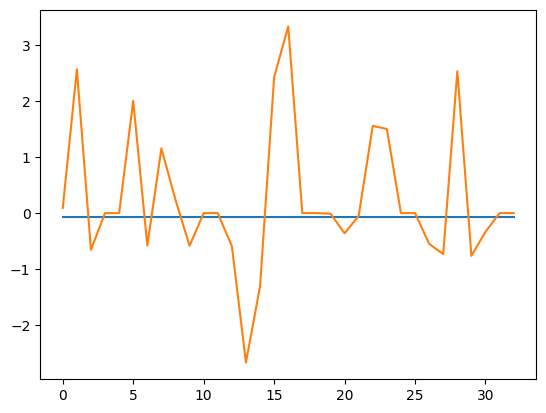

In [ ]:
plt.plot([i for i in range(33)], results)
plt.plot([i for i in range(33)], y_test)

## inne

In [ ]:
# Build the model
model = tf.keras.models.Sequential([
  #tf.keras.layers.InputLayer((14,29)),
  #tf.keras.layers.Conv1D(filters=64, kernel_size=2,
   #                   strides=1, padding="causal",
    #                  activation="relu"),
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[21, 30]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(4, 'relu'),
  tf.keras.layers.Dense(1, 'linear')
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
13/13 [==============================] - 6s 41ms/step - loss: nan - lr: 1.0000e-08
Epoch 2/100
13/13 [==============================] - 1s 36ms/step - loss: nan - lr: 1.1220e-08
Epoch 3/100
13/13 [==============================] - 1s 32ms/step - loss: nan - lr: 1.2589e-08
Epoch 4/100
13/13 [==============================] - 0s 23ms/step - loss: nan - lr: 1.4125e-08
Epoch 5/100
13/13 [==============================] - 0s 24ms/step - loss: nan - lr: 1.5849e-08
Epoch 6/100
13/13 [==============================] - 0s 24ms/step - loss: nan - lr: 1.7783e-08
Epoch 7/100
13/13 [==============================] - 0s 25ms/step - loss: nan - lr: 1.9953e-08
Epoch 8/100
13/13 [==============================] - 0s 24ms/step - loss: nan - lr: 2.2387e-08
Epoch 9/100
13/13 [==============================] - 0s 25ms/step - loss: nan - lr: 2.5119e-08
Epoch 10/100
13/13 [==============================] - 0s 24ms/step - loss: nan - lr: 2.8184e-08
Epoch 11/100
13/13 [=============================